In [0]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets, models
from torchvision.utils import save_image
import os

In [0]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [0]:
learning_rate= 0.0002
batch_size = 100
num_epochs = 10
n_noise = 100

In [0]:
sample_dir = 'samples'

if not os.path.exists(sample_dir):
  os.makedirs(sample_dir)

In [0]:
dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transforms.ToTensor(), download=True)

data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [0]:
def to_onehot(y, num_classes=10):
  # input.shape = (batch_size, 1)
  out = torch.zeros(y.size(0), num_classes, 28, 28)
  for i, num in enumerate(y.long()) :
    out[i, num, :, :] = 1
    
  D_out = out
  G_out = out[:, :, :4, :4]
  
  return D_out.to(device), G_out.to(device) 

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.conv_image = nn.Sequential(nn.Conv2d(1, 64, kernel_size=1, stride=1, padding=0, bias=False))
    
    self.conv_label = nn.Sequential(nn.Conv2d(10, 64, kernel_size=1, stride=1, padding=0, bias=False))
    
    self.conv = nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False), 
                              nn.BatchNorm2d(256), # (n, 64, 14, 14)
                              nn.ReLU(True),
                              nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                              nn.BatchNorm2d(512), # (n, 128, 7, 7)
                              nn.ReLU(True),
                              nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
                              nn.ReLU(True),       # (n, 256, 4, 4)
                              nn.AvgPool2d(4))
    
    
    self.fc = nn.Sequential(nn.Linear(1024, 512),
                            nn.BatchNorm1d(512),
                            nn.ReLU(),
                            nn.Linear(512, 256),
                            nn.BatchNorm1d(256),
                            nn.ReLU(),
                            nn.Linear(256, 1),
                            nn.Sigmoid())
    
  def forward(self, x, c, D=True):
        
    
    x = self.conv_image(x)    # (n, 64, 28, 28)
    c = self.conv_label(c)    # (n, 64, 28, 28)
    x = torch.cat([x, c], 1) # (n, 128, 28, 28)
    
    out = self.conv(x)
    out = out.view(out.size(0), -1)
    out = self.fc(out)
    return out
  
###################################################################
###################################################################

class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.noise = nn.Linear(n_noise, 246 * 4 * 4)
    
    self.convT = nn.Sequential(nn.ConvTranspose2d(256, 128, kernel_size=4, stride=1, padding=0), # (n, 128, 7, 7)
                               nn.BatchNorm2d(128),
                               nn.LeakyReLU(0.2, True),
                               nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (n, 64, 14, 14)
                               nn.BatchNorm2d(64),
                               nn.LeakyReLU(0.2, True),
                               nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),    # (n, 1, 28, 28)
                               nn.Tanh())
    
  def forward(self, x, c):
    x = self.noise(x) # (n, 10 * 4 * 4)
    x = x.view(x.size(0), 246, 4, 4)
    x = torch.cat([x, c], 1)
    
    out = self.convT(x)
    return out

In [0]:
D = Discriminator().to(device)
G = Generator().to(device)

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas=(0.5, 0.999))

def zero_grad():
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()
  
def norm(images):
  return images*2 - 1
  
def denorm(images):
  images = (images+1)/2
  return images.clamp(0,1)


In [0]:
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(data_loader):
    images = images.to(device)
    images = norm(images)
    labels = labels.view(labels.size(0),-1).to(device)  # (1, batch_size) -> (batch_size, 1)
    d_labels, g_labels = to_onehot(labels)
    
    real_labels = torch.ones(images.size(0), 1).to(device)
    fake_labels = torch.zeros(images.size(0), 1).to(device)
    #===================================================
    #                 Train Discriminator
    # ==================================================
    outputs = D(images, d_labels)
    d_loss_real = criterion(outputs, real_labels)
    
    z = torch.randn(images.size(0), n_noise).to(device)
    fake_image = G(z, g_labels)
    outputs = D(fake_image, d_labels)
    d_loss_fake = criterion(outputs, fake_labels)
    
    
    d_loss = d_loss_real + d_loss_fake
    
    zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    #===================================================
    #                 Train Generator
    # ==================================================
    z = torch.randn(images.size(0), n_noise).to(device)
    fake_image = G(z, g_labels)
    outputs_fake = D(fake_image, d_labels)
    g_loss = criterion(outputs_fake, real_labels)
    
    zero_grad()
    g_loss.backward()
    g_optimizer.step()
    
    
    if (i+1) % 100 == 0:
      print('Epoch [{}/{}], Step [{}/{}], d_loss [{:.4f} : {:.4f}], g_loss : {:.4f}'
            .format(epoch, num_epochs, i+1, len(data_loader), d_loss_real.item(), d_loss_fake.item(), g_loss.item()))
      
  if (epoch+1) == 1:
    images = images.view(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
  fake_image = fake_image.view(fake_image.size(0), 1, 28, 28)
  save_image(denorm(fake_image), os.path.join(sample_dir, 'fake_images={}.png'.format(str(epoch).zfill(3))))

In [0]:
from matplotlib.pyplot import imshow, imsave
import numpy as np
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
      
        c = torch.zeros([10, 1]).to(device)
        c[:, :] = j
        _, c = to_onehot(c)
        
        z = torch.randn(10, n_noise).to(device)
        y_hat = G(z, c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

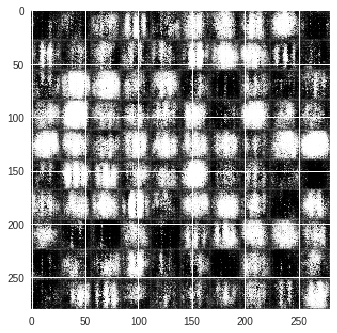

In [0]:
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')